Implemente los métodos AB5 y AM5 en MATLAB o Phyton. Primero AB5 como método explícito independiente, luego AM5 como método implícito independiente y finalmente una tercera rutina que utilice AB5 como predictor y AM5 como corrector. En todos los casos use un método Runge-Kutta apropiado para inicializar los métodos.
Ponga a prueba los métodos con los siguientes PVIs:

*   $y'=-2ty^2,t\in (0,1),  y(0)=1$. Con solución exacta $y(t)=1/(1+t^2)$.
*  $y'=t+2ty,t\in (0,1),  y(0)=0$. Con solución exacta $y(t)=\frac{1}{2}(e^{t^2}-1)$.

  En cada caso, grafique la solución numérica encontrada comparada con la solución exacta y haga estimaciones numéricas del orden del método.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

In [41]:
# Auxiliary Functions
def convergence_order(e1: float, e2: float, n1: int, n2: int) -> float:
    return np.log(e1 / e2) / np.log(n2 / n1)


def plot_solution(t_vals, y_vals, exact_vals, title):
    plt.figure(figsize=(8, 4))
    plt.plot(t_vals, y_vals, "o", color="red", label="Numerical")
    plt.plot(t_vals, exact_vals, "-", color="teal", label="Exact")
    plt.xlabel("Time")
    plt.ylabel("Y(t)")
    plt.title(title)
    plt.grid(linestyle="--")
    plt.legend()
    plt.show()

def run_simulation(method, method_name, dy_dt, exact, y0, t0, tf, N_values):
    results = {"N": [], "h": [], "y_aprox": [], "y_exact": [], "error": [], "convergence_rate": []}
    for N in N_values:
        h = (tf - t0) / N
        t_vals, y_vals = method(dy_dt, y0, t0, tf, h)
        y_aprox, y_exact = y_vals[-1], exact(t_vals[-1])
        error = abs(y_aprox - y_exact)
        
        results["N"].append(N)
        results["h"].append(h)
        results["y_aprox"].append(y_aprox)
        results["y_exact"].append(y_exact)
        results["error"].append(error)
        
        if len(results["y_aprox"]) > 1:
            results["convergence_rate"].append(
                convergence_order(
                    results["error"][-2], results["error"][-1], results["N"][-2], results["N"][-1]
                )
            )
        plot_solution(t_vals, y_vals, exact(t_vals), f"{method_name} with N={N}")
    results["convergence_rate"].append(0)
    return pd.DataFrame(results)


###  $y'=-2ty^2,t\in (0,1),  y(0)=1$. 
### Con solución exacta $y(t)=1/(1+t^2)$.

In [42]:
t0, tf, y0 = 0, 1, 1
N_values = [8, 16, 32, 64, 128]

def function_1(t, y):
    return -2 * t * y**2

def exact_solution_1(t):
    return 1 / (1 + t**2)

problem_1_args = (function_1, exact_solution_1, y0, t0, tf, N_values)

In [43]:
def runge_kutta_5(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + 0.25 * h, y + 0.25 * k1 * h)
    k3 = f(t + 0.25 * h, y + 0.125 * h * (k1 + k2))
    k4 = f(t + 0.5 * h, y - 0.5 * k2 * h + k3 * h)
    k5 = f(t + 0.75 * h, y + 3 * k1 * h / 16 + 9 * k4 * h / 16)
    k6 = f(
        t + h,
        y - (3 / 7) * k1 * h + (2 / 7) * k2 * h + (12 / 7) * k3 * h 
        - (12 / 7) * k4 * h + (8 / 7) * k5 * h,
    )
    return y + (h / 90) * (7 * k1 + 32 * k3 + 12 * k4 + 32 * k5 + 7 * k6)

In [44]:
def ab5_step(y_values, t_values, f, i, h):
    coefficients = [1901/720, -2774/720, 2616/720, -1274/720, 251/720]
    return y_values[i] + h * sum(
        c * f(t_values[i - j], y_values[i - j]) for j, c in enumerate(coefficients)
    )

In [45]:
def ab5(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    y_values = np.zeros_like(t_values)
    y_values[0] = y0
    
    for i in range(5):
        y_values[i + 1] = runge_kutta_5(f, t_values[i], y_values[i], h)
    
    for i in range(5, len(t_values) - 1):
        y_values[i + 1] = ab5_step(y_values, t_values, f, i, h)
    
    return t_values, y_values

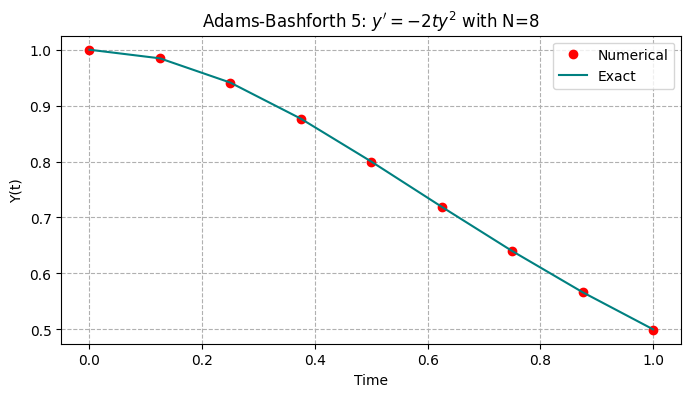

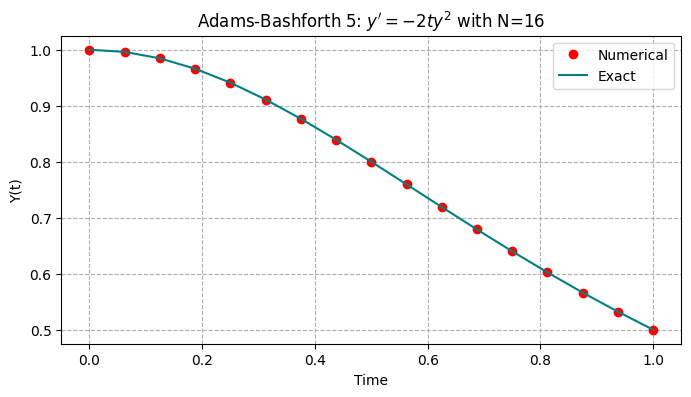

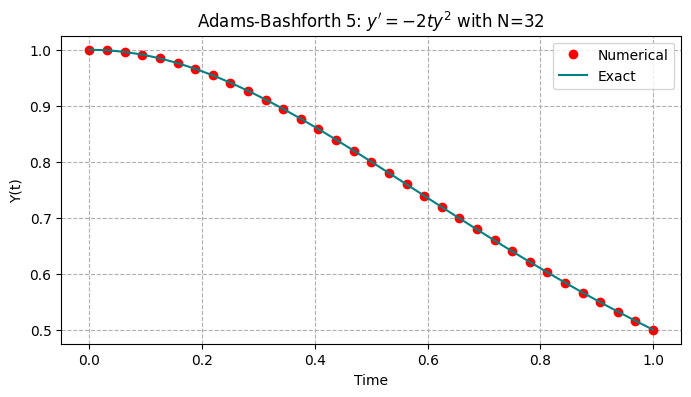

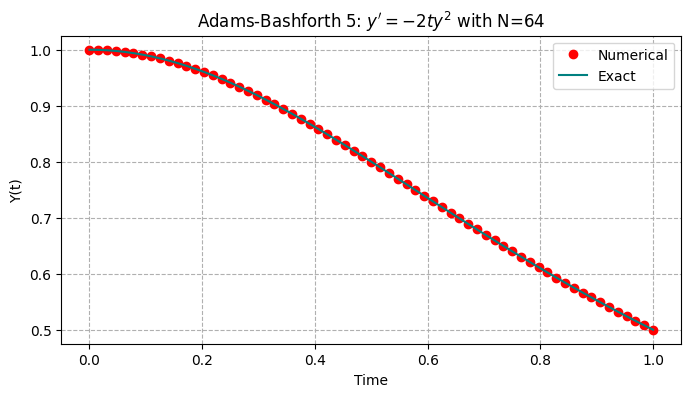

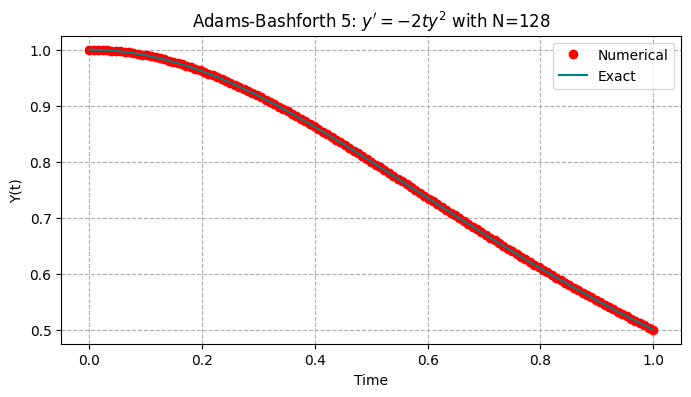

,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.499320,0.5,6.803555e-04,5.336667
1,16,0.062500,0.499983,0.5,1.683601e-05,5.530933
2,32,0.031250,0.500000,0.5,3.641350e-07,5.492068
3,64,0.015625,0.500000,0.5,8.090681e-09,5.347652
4,128,0.007812,0.500000,0.5,1.986925e-10,0.000000


In [46]:
results = ab5_results = run_simulation(ab5, "Adams-Bashforth 5: $y'=-2ty^2$", *problem_1_args)
results

In [47]:
def am5(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    y_values = np.zeros_like(t_values)
    y_values[0] = y0
    
    coefficients = [251/720, 646/720, -264/720, 106/720, -19/720]
    def g(y_next, t, c, h):
        return y_next - (coefficients[0] * h) * f(t, y_next) - c
    
    for i in range(4):
        y_values[i + 1] = runge_kutta_5(f, t_values[i], y_values[i], h)
    
    for i in range(3, len(t_values) - 1):
        c = y_values[i] + h * sum(coefficients[j+1] * f(t_values[i - j], y_values[i - j]) for j in range(4))
        y_values[i + 1] = fsolve(g, y_values[i], args=(t_values[i + 1], c, h))[0]
    return t_values, y_values

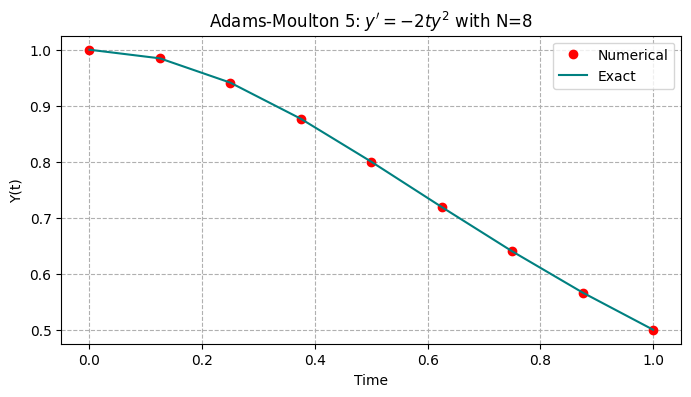

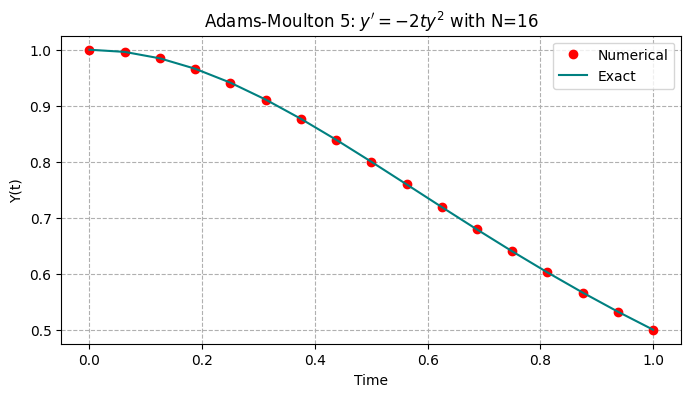

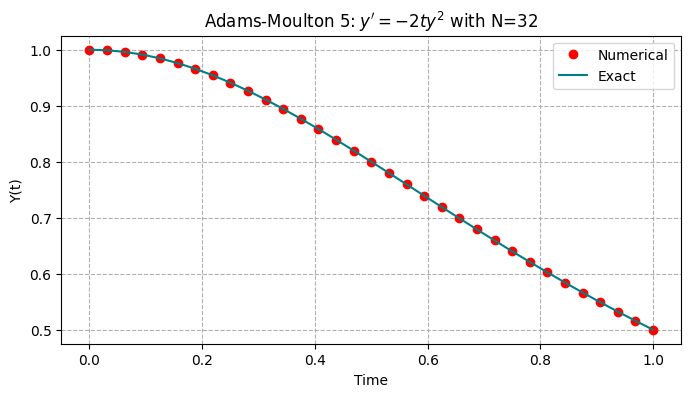

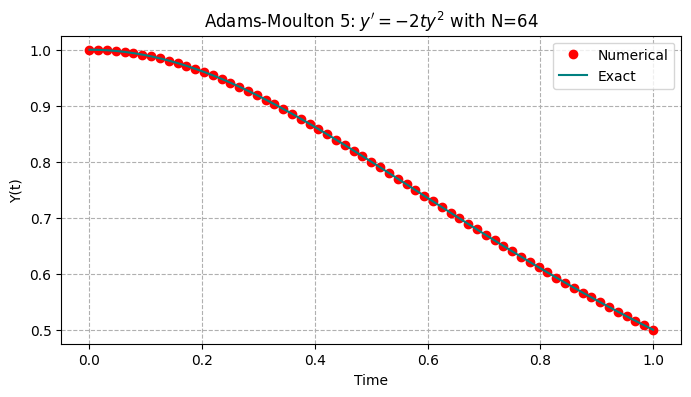

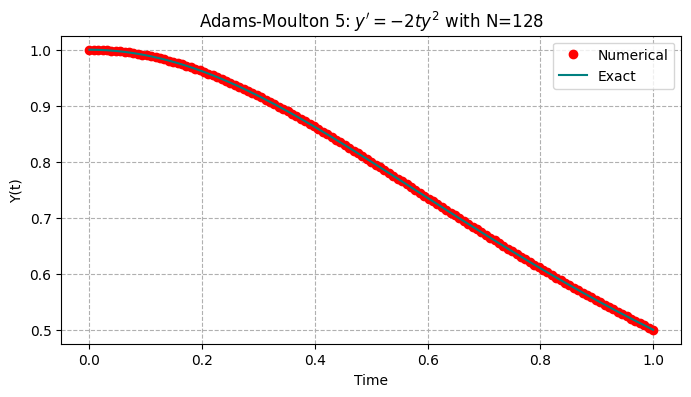

,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.500032,0.5,3.243575e-05,5.476940
1,16,0.062500,0.500001,0.5,7.282841e-07,5.515917
2,32,0.031250,0.500000,0.5,1.591639e-08,5.385514
3,64,0.015625,0.500000,0.5,3.807529e-10,5.241714
4,128,0.007812,0.500000,0.5,1.006306e-11,0.000000


In [48]:
results = run_simulation(am5, "Adams-Moulton 5: $y'=-2ty^2$", *problem_1_args)
results

In [49]:
def am5_pc(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    y_values = np.zeros_like(t_values)
    y_values[0] = y0
    
    coefficients = [251/720, 646/720, -264/720, 106/720, -19/720]
    for i in range(5):
        y_values[i + 1] = runge_kutta_5(f, t_values[i], y_values[i], h)
    
    for i in range(4, len(t_values) - 1):
        y_predicted = ab5_step(y_values, t_values, f, i, h)
        y_corrected = y_values[i] + h * sum(
            coefficients[j] * f(t_values[i + 1 - j], y_predicted if j == 0 else y_values[i + 1 - j])
            for j in range(5)
        )
        y_values[i + 1] = y_corrected
    return t_values, y_values

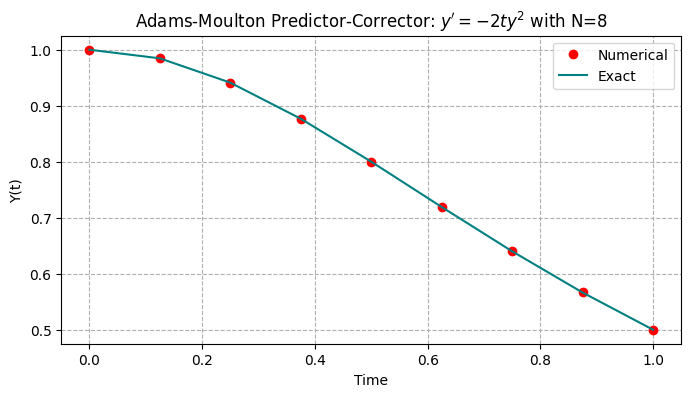

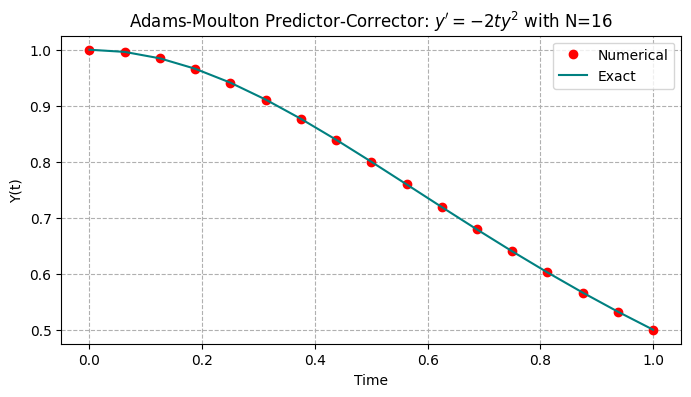

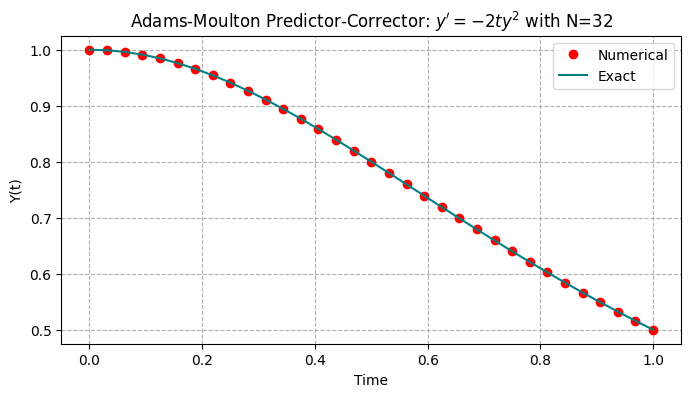

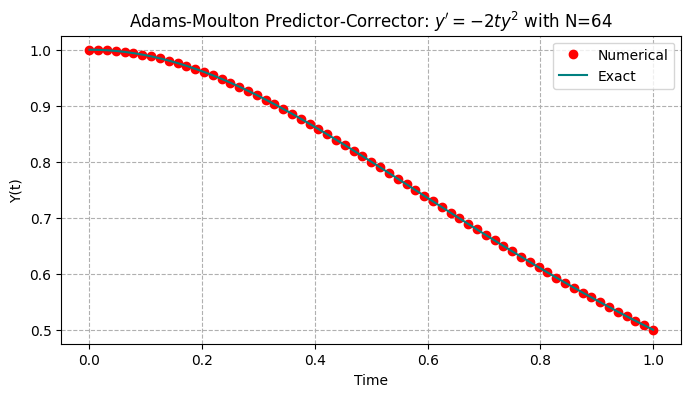

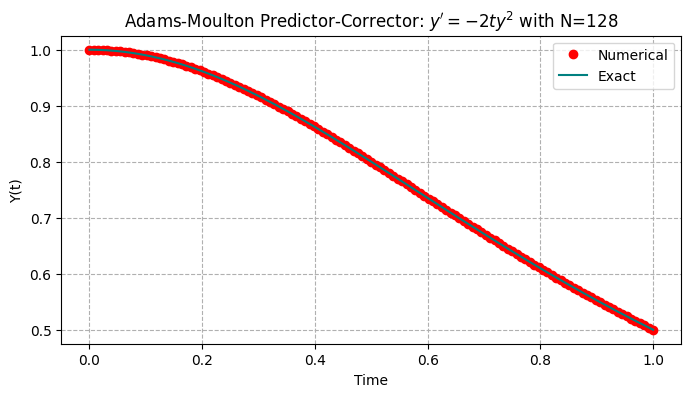

,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.500092,0.5,9.208610e-05,5.924723
1,16,0.062500,0.500002,0.5,1.515915e-06,5.845171
2,32,0.031250,0.500000,0.5,2.636956e-08,5.633800
3,64,0.015625,0.500000,0.5,5.310803e-10,5.431960
4,128,0.007812,0.500000,0.5,1.230205e-11,0.000000


In [51]:
results = run_simulation(am5_pc, "Adams-Moulton Predictor-Corrector: $y'=-2ty^2$", *problem_1_args)
results

### $y'=t+2ty,t\in (0,1),  y(0)=0$. 
### Con solución exacta $y(t)=\frac{1}{2}(e^{t^2}-1)$.

In [52]:
t0, tf, y0 = 0, 1, 0
N_values = [8, 16, 32, 64, 128]

def function_2(t, y):
    return t + 2 * t * y


def exact_solution_2(t):
    return 0.5 * (np.exp(t**2) - 1)

problem_2_args = (function_2, exact_solution_2, y0, t0, tf, N_values)

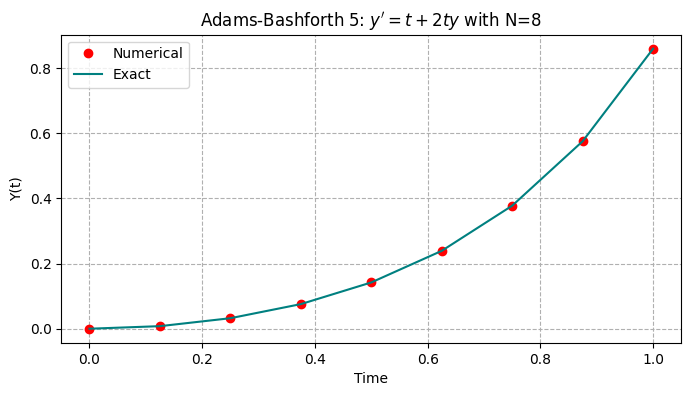

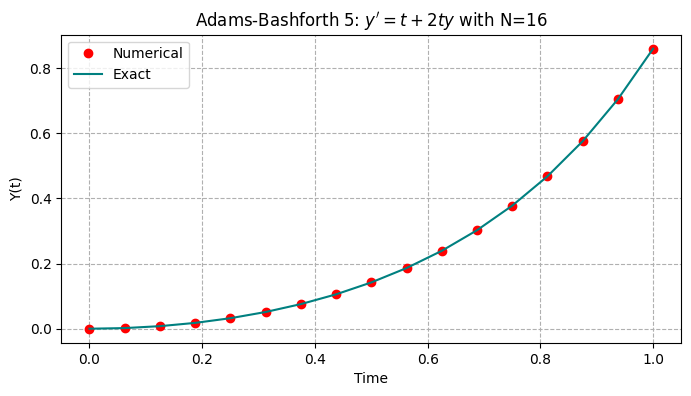

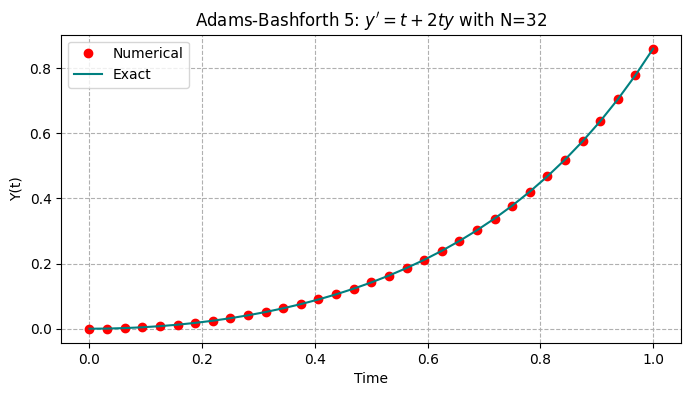

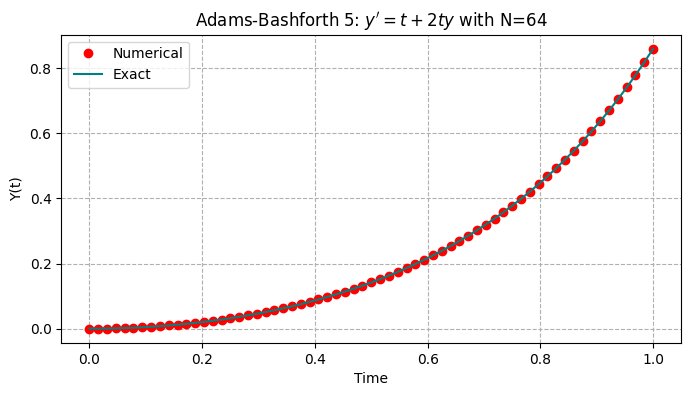

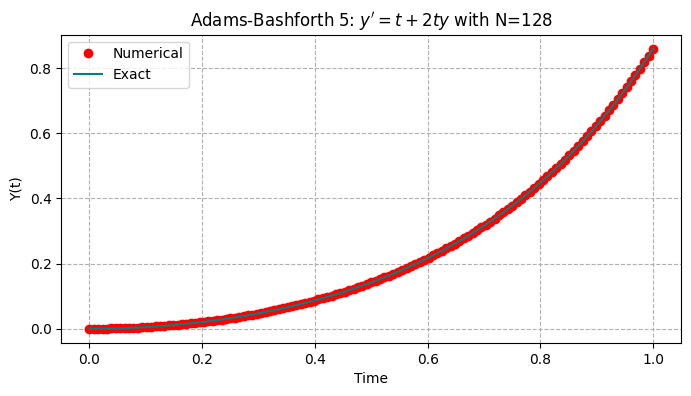

,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.857624,0.859141,1.517328e-03,3.842294
1,16,0.062500,0.859035,0.859141,1.057874e-04,4.532953
2,32,0.031250,0.859136,0.859141,4.569610e-06,4.776546
3,64,0.015625,0.859141,0.859141,1.667230e-07,4.889616
4,128,0.007812,0.859141,0.859141,5.624376e-09,0.000000


In [53]:
results = run_simulation(ab5, "Adams-Bashforth 5: $y'=t+2ty$", *problem_2_args)
results

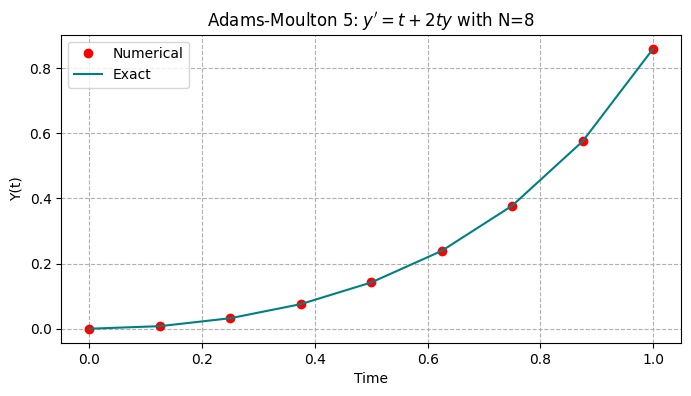

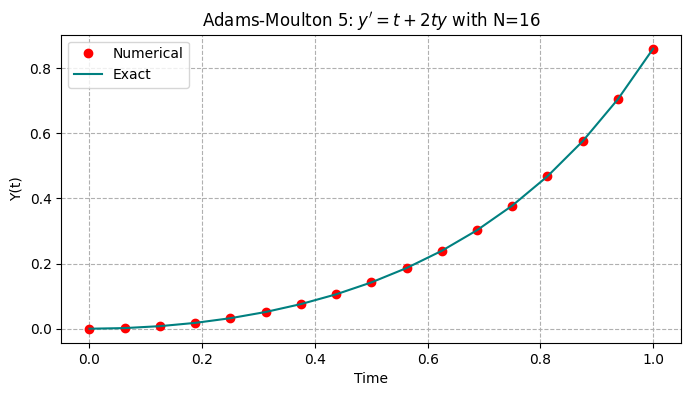

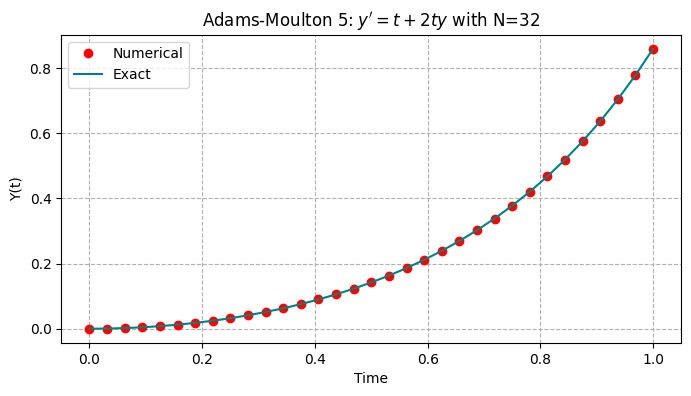

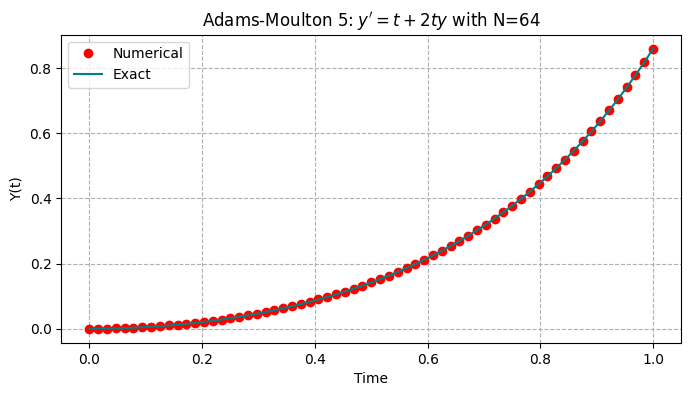

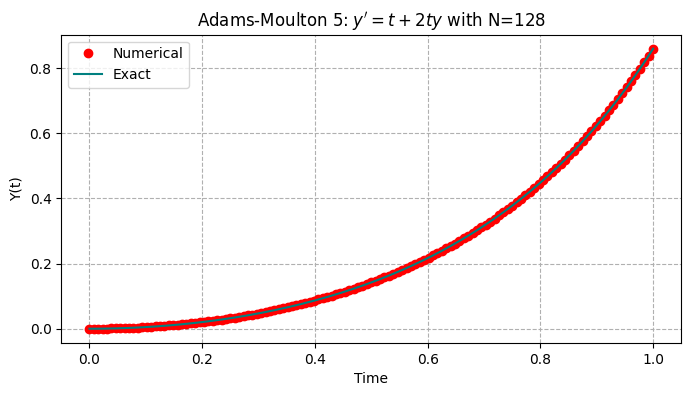

,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.859310,0.859141,1.690436e-04,4.436277
1,16,0.062500,0.859149,0.859141,7.808117e-06,4.731722
2,32,0.031250,0.859141,0.859141,2.938705e-07,4.867101
3,64,0.015625,0.859141,0.859141,1.006961e-08,4.933661
4,128,0.007812,0.859141,0.859141,3.294827e-10,0.000000


In [54]:
results = run_simulation(am5, "Adams-Moulton 5: $y'=t+2ty$", *problem_2_args)
results

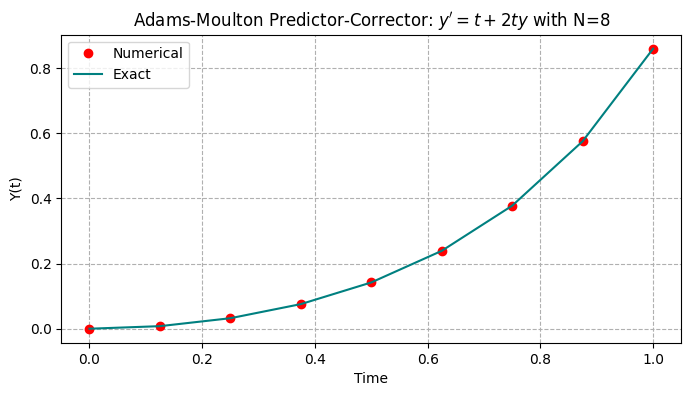

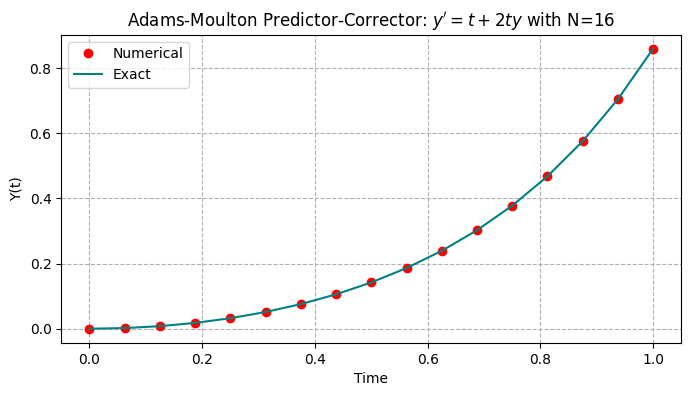

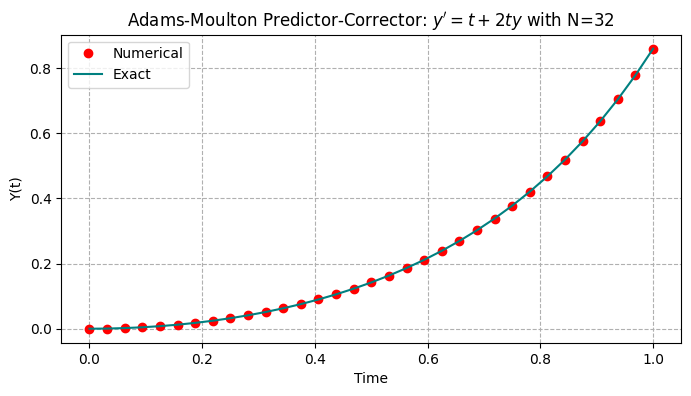

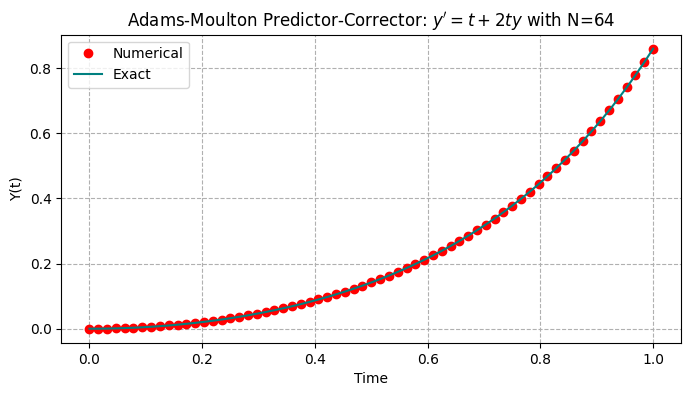

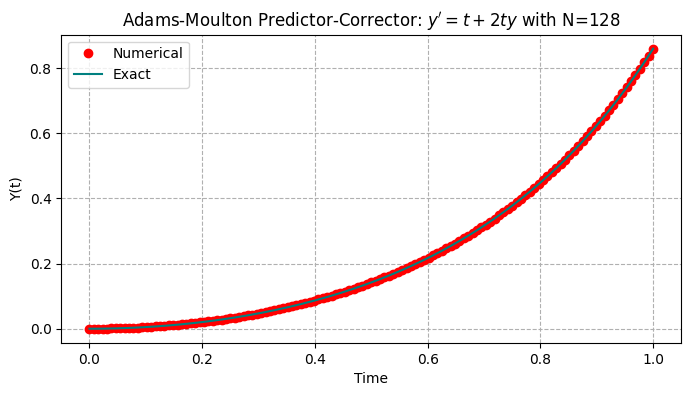

,N,h,y_aprox,y_exact,error,convergence_rate
0,8,0.125000,0.859158,0.859141,1.677546e-05,2.134057
1,16,0.062500,0.859145,0.859141,3.821723e-06,4.160652
2,32,0.031250,0.859141,0.859141,2.136871e-07,4.627365
3,64,0.015625,0.859141,0.859141,8.645751e-09,4.821566
4,128,0.007812,0.859141,0.859141,3.057502e-10,0.000000


In [55]:
results = run_simulation(am5_pc, "Adams-Moulton Predictor-Corrector: $y'=t+2ty$", *problem_2_args)
results